In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import cv2

matplotlib.use("Agg")

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,LambdaCallback
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K

from imutils import build_montages
from sklearn.metrics import classification_report

In [3]:
class MiniVGGNet:
    @staticmethod
    def build(width, height, depth, classes):
        # initialize the model along with the input shape to be
        # "channels last" and the channels dimension itself
        model = Sequential()
        inputShape = (height, width, depth)
        chanDim = -1
        
        model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(32, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.3))
        
        #second CONV => RELU => CONV => RELU => POOL layer set
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.3))

        # first (and only) set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(512))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        
        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))
        # return the constructed network architecture
        return model

In [4]:
# initialize the number of epochs to train for, base learning rate,
# and batch size
NUM_EPOCHS = 50
INIT_LR = 1e-2
BS = 32

((trainX, trainY), (testX, testY)) = fashion_mnist.load_data()

trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
testX = testX.reshape((testX.shape[0], 28, 28, 1))

trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0

# one-hot encode the training and testing labels
trainY = to_categorical(trainY, 10)
testY = to_categorical(testY, 10)

# initialize the label names
labelNames = ["top", "trouser", "pullover", "dress", "coat","sandal", "shirt", "sneaker", "bag", "ankle boot"]

In [19]:
train_gen = ImageDataGenerator()
test_gen = ImageDataGenerator()

training_set= train_gen.flow(trainX, trainY, batch_size=32)
test_set= train_gen.flow(testX, testY, batch_size=32)

In [20]:
opt = SGD(lr=INIT_LR, momentum=0.9, decay=INIT_LR / NUM_EPOCHS)
#opt = Adam(learning_rate=0.01)
model = MiniVGGNet.build(width=28, height=28, depth=1, classes=10)
model.compile(loss="categorical_crossentropy", optimizer = opt,metrics=["accuracy"])

# define the checkpoint
filepath = "C:\\Users\\Ankit Gala\\python-projects\\image-classification\\fashion-mnist\\vgg-checkpoint-25"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
checkpoint2 = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
#early_stop = EarlyStopping(monitor='val_loss',patience=3)
callbacks_list = [checkpoint]

In [21]:
# train the network
print("[INFO] training model...")
H = model.fit(training_set,
                        validation_data= test_set, 
                        #batch_size=BS,
                        epochs=NUM_EPOCHS, 
                        callbacks=callbacks_list)

[INFO] training model...
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1875 steps, validate for 313 steps
Epoch 1/50
1874/1875 [============================>.] - ETA: 0s - loss: 0.5776 - accuracy: 0.8076
Epoch 00001: val_loss improved from inf to 0.34800, saving model to C:\Users\Ankit Gala\python-projects\image-classification\fashion-mnist\vgg-checkpoint-25
INFO:tensorflow:Assets written to: C:\Users\Ankit Gala\python-projects\image-classification\fashion-mnist\vgg-checkpoint-25\assets
1875/1875 [==============================] - 209s 112ms/step - loss: 0.5775 - accuracy: 0.8076 - val_loss: 0.3480 - val_accuracy: 0.8781
Epoch 2/50
1874/1875 [============================>.] - ETA: 0s - loss: 0.3713 - accuracy: 0.8683
Epoch 00002: val_loss improved from 0.34800 to 0.29344, saving model to C:\Users\Ankit Gala\python-projects\image-classification\fashion-mnist\vgg-checkpoint-25
INFO:tensorflow:Assets written to: C:\Users\Ankit Gala\python-projects\image-classification\fashio

In [22]:
### save and load model
model.save("C:\\Users\\Ankit Gala\\python-projects\\image-classification\\fashion-mnist\\fashion-mnist-model-25-2.h5")

#model = load_model('C:\\Users\\Ankit Gala\\python-projects\\image-classification\\fashion-mnist\\fashion-mnist-model-25-2.h5')

In [23]:
# make predictions on the test set
preds = model.predict(testX)
# show a nicely formatted classification report
print("[INFO] evaluating network...")
print(classification_report(testY.argmax(axis=1), preds.argmax(axis=1),target_names=labelNames))

[INFO] evaluating network...
              precision    recall  f1-score   support

         top       0.87      0.92      0.89      1000
     trouser       1.00      0.99      0.99      1000
    pullover       0.89      0.92      0.90      1000
       dress       0.93      0.95      0.94      1000
        coat       0.91      0.89      0.90      1000
      sandal       0.99      0.99      0.99      1000
       shirt       0.84      0.76      0.80      1000
     sneaker       0.97      0.99      0.98      1000
         bag       0.99      0.99      0.99      1000
  ankle boot       0.98      0.97      0.98      1000

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



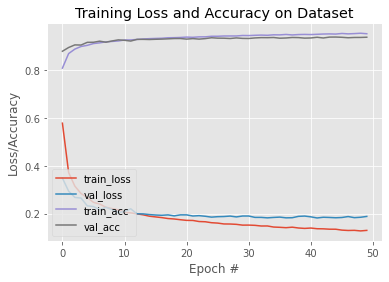

In [24]:
# plot the training loss and accuracy
%matplotlib inline

N = 50
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

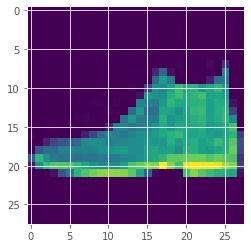

In [25]:
plt.imshow(testX[0].reshape(28,28))
#testX[i].reshape(60000,28,28,1)

In [26]:
import pandas as pd
test_csv = pd.read_csv("C:\\Users\\Ankit Gala\\python-projects\\image-classification\\fashion-mnist\\test.csv")

In [27]:
test_csv.head()

,id,label
0,60001,9
1,60002,2
2,60003,1
3,60004,1
4,60005,6


In [28]:
test_csv["label"] = preds.argmax(axis=1)

In [29]:
test_csv.to_csv("C:\\Users\\Ankit Gala\\python-projects\\image-classification\\fashion-mnist\\test.csv",index = False)